In [26]:
import mne
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.stats.anova import AnovaRM
from scipy import signal
from scipy.fft import fftshift
# from compute_abr import *
from bids import BIDSLayout

In [2]:
BIDS_ROOT = '../data/bids'
FS = 5000
stim_freqs = [130, 200, 280]

cond_dict = {
    (130, 1, 'l', True): ['211', '212', '213'],
    (200, 2, 'l', True): ['221', '222', '223'],
    (280, 3, 'l', True): ['231', '232', '233'],
    (130, 1, 'r', True): ['111', '121', '131'],
    (200, 2, 'r', True): ['112', '122', '132'],
    (280, 3, 'r', True): ['113', '123', '133'],
    (130, 1, 'l', False): ['111', '112', '113'],
    (200, 2, 'l', False): ['121', '122', '123'],
    (280, 3, 'l', False): ['131', '132', '133'],
    (130, 1, 'r', False): ['211', '221', '231'],
    (200, 2, 'r', False): ['212', '222', '232'],
    (280, 3, 'r', False): ['213', '223', '233']
}

right_channels = ['AF4','C2','C4','C6','T8','CP2','CP4','CP6','F2','F4','F6','F8','FC2','FC4','FC6','FT10','FT8','Fp2','O2','P2','P4','P6','P8','PO4','PO8','TP10','TP8']
left_channels = ['AF3', 'C1','C3','C5','T7','CP1','CP3','CP5','F1','F3','F5','F7','FC1','FC3','FC5','FT7','FT9','Fp1','O1','P1','P3','P5','P7','PO3','PO7','TP7','TP9']


In [15]:
def read_epochs(sub, desc):
    '''
    reads and concatenates epochs across runs
    vendored from John
    '''
    layout = BIDSLayout(BIDS_ROOT, derivatives = True)
    run = lambda f: int(re.findall('run-(\w+)_', f)[0])
    fnames = layout.get(
        return_type = 'filename',
        subject = sub, 
        desc = desc
        )
    fnames.sort(key = run)
    epochs_all = [mne.read_epochs(f) for f in fnames]
    epochs = mne.concatenate_epochs(epochs_all)
    epochs = epochs.pick('eeg')
    return epochs

def get_dB(epochs):
    P = epochs.average().compute_psd(tmin = 0, tmax = 0.4, fmin = 100, fmax = 300)
    P0 = epochs.average().compute_psd(tmin = -0.4, tmax = 0, fmin = 100, fmax = 300)
    dB = 10*np.log10(P.get_data()/P0.get_data())
    dB = np.squeeze(dB)
    return dB, P.freqs

def get_hemisphere(ch_names):
    left_channels = ['AF3', 'C1','C3','C5','T7','CP1','CP3','CP5','F1','F3','F5','F7','FC1','FC3','FC5','FT7','FT9','Fp1','O1','P1','P3','P5','P7','PO3','PO7','TP7','TP9']
    right_channels = ['AF4','C2','C4','C6','T8','CP2','CP4','CP6','F2','F4','F6','F8','FC2','FC4','FC6','FT10','FT8','Fp2','O2','P2','P4','P6','P8','PO4','PO8','TP10','TP8']
    hemisphere = []
    for channel in epochs.ch_names:
        if channel in left_channels:
            hemisphere.append("left")
        elif channel in right_channels:
            hemisphere.append("right")
        else:
            hemisphere.append("middle")
    return hemisphere

def get_hemisphere_ch_names(ch_names, hemisphere_channels):
    hemisphere_ch_names = set(ch_names).intersection(set(hemisphere_channels))
    return list(hemisphere_ch_names)

def get_channel_coords(coords, channel_names):
    x_coords = []
    y_coords = []
    for channel in channel_names:
        x_coord = coords['x'][coords['ch_name'] == channel]
        x_coord = x_coord.tolist()[0]
        x_coords.append(x_coord)
        y_coord = coords['y'][coords['ch_name'] == channel]
        y_coord = y_coord.tolist()[0]
        y_coords.append(y_coord)

    return(x_coords, y_coords)

def plot_dB(ax, dB, freqs, attend, stim_freq):
    ax.plot(freqs, dB, label = attend)
    ax.set_xlabel('frequency')
    ax.set_ylabel('dB')
    ax.axvline(stim_freq, linestyle = '--', color = 'grey')
    ax.legend(title = 'Attend')

In [27]:
coords = pd.read_csv('../data/captrak/2dcoords.csv')
layout = BIDSLayout(BIDS_ROOT, derivatives = True)
subs = layout.get_subjects(scope = 'preprocess_ffr')
all_spectrums = []

for sub in subs:
    # Load data
    epochs = read_epochs(sub, 'forFFR')
    
    # Iterate over conditions
    for condition, event_ids in cond_dict.items():
        stim = condition[0]
    
        # Compute dB for each channel
        cond_epochs = epochs[event_ids]
        dB, freq = get_dB(cond_epochs) # dB should be n_chans * n_freq

        # Create data frame (channel name, hemisphere, stim_freq, stream, attended, dB)
        df = pd.DataFrame(
            {'sub': sub,
             'freq': freq,
             'stim': stim,
             'stream': condition[2],
             'attended': condition[3],
             'dB': dB
            }
        )
        all_spectrums.append(df)
#         break
#     break

spectrums = pd.concat(all_spectrums)
spectrums.to_csv('spectrums.csv', sep = '\t', index = False)

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-33/sub-33_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1841 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1841 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper sp

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-8/sub-8_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1748 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1748 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spec

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-41/sub-41_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1830 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1830 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper sp

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-40/sub-40_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1798 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1798 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper sp

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-5/sub-5_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1222 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1222 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spec

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-25/sub-25_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
29 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectr

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/tmp/ipykernel_24003/1215958834.py:20: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  P = epochs.average().compute_psd(tmin = 0, tmax = 0.4, fmin = 100, fmax = 300)
/tmp/ipykernel_24003/1215958834.py:21: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  P0 = epochs.average().compute_psd(tmin = -0.4, tmax = 0, fmin = 100, fmax = 300)
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/letitiayhho/.conda/envs/pitch-tracking/lib/py

Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-9/sub-9_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
936 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
936 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectr

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-11/sub-11_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
346 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
346 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spec

## Plot

In [64]:
spectrums = pd.read_csv('spectrums.csv', sep = '\t')
spectrums

,sub,freq,stim,stream,attended,dB
0,33,102.329451,130,l,True,-2.169219
1,33,104.825291,130,l,True,-1.764144
2,33,107.321131,130,l,True,-1.698588
3,33,109.816972,130,l,True,-0.760749
4,33,112.312812,130,l,True,1.547259
...,...,...,...,...,...,...
7675,11,289.517471,280,r,False,-0.973288
7676,11,292.013311,280,r,False,-2.437389
7677,11,294.509151,280,r,False,-2.885365
7678,11,297.004992,280,r,False,-2.838333


(100.0, 300.0)

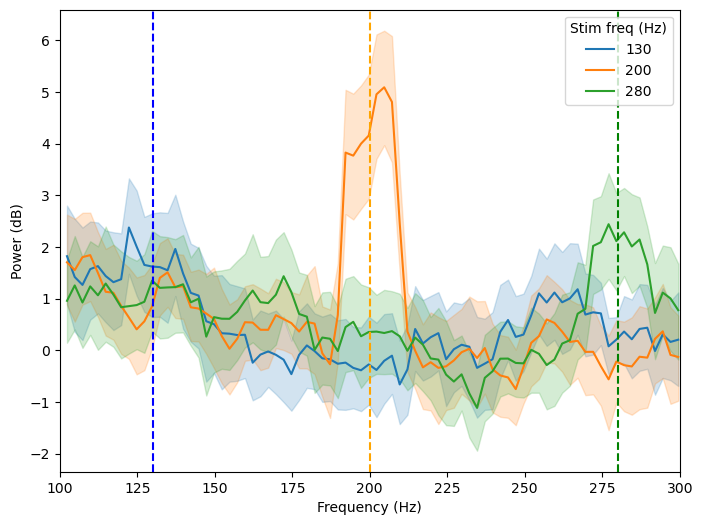

In [67]:
fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = spectrums, x = "freq", y = "dB", hue = "stim", palette = 'tab10', ax = ax)
graph.axvline(130, linestyle = 'dashed', color = 'blue')
graph.axvline(200, linestyle = 'dashed', color = 'orange')
graph.axvline(280, linestyle = 'dashed', color = 'green')
graph.legend(title = 'Stim freq (Hz)')
graph.set_ylabel("Power (dB)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(100, 300)

### Basic ANOVA

In [45]:
coords = pd.read_csv('../data/captrak/2dcoords.csv')
layout = BIDSLayout(BIDS_ROOT, derivatives = True)
subs = layout.get_subjects(scope = 'preprocess_ffr')
stim_spectrums = []

for sub in subs:
    # Load data
    epochs = read_epochs(sub, 'forFFR')
    
    # Iterate over conditions
    for condition, event_ids in cond_dict.items():
        stim = condition[0]
    
        # Compute dB for each channel
        cond_epochs = epochs[event_ids]
        dB, freqs = get_dB(cond_epochs) # dB should be n_chans * n_freq

        # Iterate over stim freqs
        for freq in stim_freqs:
        
            # select Fourier frequencies around stimulus frequency
            idx = np.abs(freqs - freq).argmin()
            freq_dB = dB[idx]
    
            # Create data frame (channel name, hemisphere, stim_freq, stream, attended, dB)
            df = pd.DataFrame(
                {'sub': sub,
                 'freq': freq,
                 'stim': stim,
                 'stream': condition[2],
                 'attended': condition[3],
                 'dB': [freq_dB]
                }
            )
        stim_spectrums.append(df)

stim_spectrums = pd.concat(stim_spectrums)
stim_spectrums = stim_spectrums.reset_index(drop = True)

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-33/sub-33_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1841 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1841 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper sp

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-8/sub-8_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1748 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1748 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spec

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-41/sub-41_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1830 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1830 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper sp

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-40/sub-40_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1798 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1798 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper sp

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-5/sub-5_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1222 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1222 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spec

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-25/sub-25_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
29 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectr

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/tmp/ipykernel_24003/1215958834.py:20: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  P = epochs.average().compute_psd(tmin = 0, tmax = 0.4, fmin = 100, fmax = 300)
/tmp/ipykernel_24003/1215958834.py:21: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  P0 = epochs.average().compute_psd(tmin = -0.4, tmax = 0, fmin = 100, fmax = 300)
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/letitiayhho/.conda/envs/pitch-tracking/lib/py

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-9/sub-9_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
936 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
936 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectr

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-11/sub-11_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
346 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
346 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spec

In [52]:
spectrums

,sub,freq,stim,stream,attended,dB
0,33,280,130,l,True,0.969441
1,33,280,200,l,True,-0.436890
2,33,280,280,l,True,-0.990476
3,33,280,130,r,True,0.030913
4,33,280,200,r,True,-0.924711
...,...,...,...,...,...,...
91,11,280,200,l,False,1.213766
92,11,280,280,l,False,-0.982187
93,11,280,130,r,False,0.220995
94,11,280,200,r,False,2.986087


In [ ]:
aov = AnovaRM(
    data = power_f0, 
    depvar = 'power',
    subject = 'sub', 
    within = ['freq', 'stim', 'stream']
)
res = aov.fit()
print(res)

In [62]:
drop_attended = spectrums.groupby(['sub', 'freq', 'stim', 'stream'], as_index = False)['dB'].mean()
aov = AnovaRM(
    data = drop_attended, 
    depvar = 'dB',
    subject = 'sub', 
    within = ['freq', 'stim', 'stream']
)
res = aov.fit()
print(res)

                    Anova
                 F Value Num DF  Den DF Pr > F
----------------------------------------------
freq                 nan 0.0000  0.0000    nan
stim              5.3374 2.0000 14.0000 0.0189
stream            0.0170 1.0000  7.0000 0.8999
freq:stim            nan 0.0000  0.0000    nan
freq:stream          nan 0.0000  0.0000    nan
stim:stream       0.8838 2.0000 14.0000 0.4350
freq:stim:stream     nan 0.0000  0.0000    nan



/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/statsmodels/stats/anova.py:591: RuntimeWarning: invalid value encountered in double_scalars
  msm = (ssr1 - ssr) / df1
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/statsmodels/stats/anova.py:601: RuntimeWarning: invalid value encountered in double_scalars
  mse = (ssr1 - ssr) / df2
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/statsmodels/stats/anova.py:591: RuntimeWarning: invalid value encountered in double_scalars
  msm = (ssr1 - ssr) / df1
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/statsmodels/stats/anova.py:601: RuntimeWarning: invalid value encountered in double_scalars
  mse = (ssr1 - ssr) / df2
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/statsmodels/stats/anova.py:591: RuntimeWarning: invalid value encountered in double_scalars
  msm = (ssr1 - ssr) / df1
/home/letitiayhho/.conda/envs/pitch

### Compute spectrum by hemisphere

In [3]:
def get_hemisphere_channels(ch_names):
    left_channels = ['AF3', 'C1','C3','C5','T7','CP1','CP3','CP5','F1','F3','F5','F7','FC1','FC3','FC5','FT7','FT9','Fp1','O1','P1','P3','P5','P7','PO3','PO7','TP7','TP9']
    right_channels = ['AF4','C2','C4','C6','T8','CP2','CP4','CP6','F2','F4','F6','F8','FC2','FC4','FC6','FT10','FT8','Fp2','O2','P2','P4','P6','P8','PO4','PO8','TP10','TP8']

    # Find channels that are missing
    missing = set(left_channels + right_channels) - set(ch_names)
    print(f'----------missing chans: {missing}')

    # Pop from both hemispheres
    for channel in missing:
        if channel in left_channels:
            i = left_channels.index(channel)
        elif channel in right_channels:
            i = right_channels.index(channel)
        right_channels.pop(i)
        left_channels.pop(i)
        
    missing = len(missing)
    return left_channels, right_channels, missing

In [18]:
coords = pd.read_csv('../data/captrak/2dcoords.csv')
layout = BIDSLayout(BIDS_ROOT, derivatives = True)
subs = layout.get_subjects(scope = 'preprocessing')
diff_spectrums = []

for sub in subs:
    # Load data
    epochs = read_epochs(sub, 'clean')
    
    # Iterate over conditions
    for condition, event_ids in cond_dict.items():
        stim = condition[0]
        
        # Pick channels for each hemisphere
        left_channels, right_channels, missing = get_hemisphere_channels(epochs.ch_names)
        left_epochs = epochs[event_ids].pick(left_channels)
        right_epochs = epochs[event_ids].pick(right_channels)

        # Compute dB for each channel
        left_dB, psd_freqs = get_dB(left_epochs) # dB should be n_chans * n_freq
        right_dB, psd_freqs = get_dB(right_epochs) # preserves the requested channel order given as its picks parameter
        dB_diff = left_dB - right_dB
        
        # Iterate over stim freqs
        for freq in stim_freqs:
        
            # select Fourier frequencies around stimulus frequency
            idx = np.abs(psd_freqs - freq).argmin()
            freq_dB_diff = dB_diff[:,idx]

            # Get channel coordinates
            x, y = get_channel_coords(coords, left_channels)

            # Create data frame (channel name, hemisphere, stim_freq, stream, attended, dB)
            df = pd.DataFrame(
                {'sub': sub,
                 'left_chs': left_channels,
                 'x': x,
                 'y': y,
                 'freq': freq,
                 'stim': stim,
                 'stream': condition[2],
                 'attended': condition[3],
                 'dB_diff': freq_dB_diff
                }
            )
            
            # Add nan column for every missing channel
            for i in range(missing):
                df.loc[-1] = ['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
            
            # Check
            if np.shape(df) != (27, 8):
                raise ValueError('df is not the right shape, some channels may be missing')
            
            diff_spectrums.append(df)
#             break
#         break
#     break

diff_spectrums = pd.concat(diff_spectrums)
diff_spectrums.to_csv('diff_spectrums.csv', sep = '\t', index = False)

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-38/sub-38_task-dichotic_run-1_desc-clean_epo.fif-1.gz ...


/tmp/ipykernel_24003/1215958834.py:14: RuntimeWarning: This filename (/project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-38/sub-38_task-dichotic_run-1_desc-clean_epo.fif-1.gz) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_all = [mne.read_epochs(f) for f in fnames]


    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Not setting metadata
1151 matching events found
No baseline correction applied
0 projection items activated
Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-38/sub-38_task-dichotic_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-38/sub-38_task-dichotic_run-1_desc-clean_epo.fif-1.gz ...
    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Not setting metadata
2303 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_24003/1215958834.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs_all)


Not setting metadata
3454 matching events found
Applying baseline correction (mode: mean)
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows


In [40]:
df